# Intel Products Sentiment Analysis

This notebook provides a comprehensive sentiment analysis of Intel product reviews using various models . The goal is to clean the data, translate reviews to English, train different models, and provide actionable insights based on customer feedback.


In [1]:
%pip install pandas
%pip install nltk
%pip install matplotlib
%pip install seaborn
%pip install jupyter
%pip install scikit-learn
%pip install tensorflow
%pip install transformers
%pip install tqdm
%pip install sacremoses
%pip install sentencepiece
%pip install tqdm
%pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.3 MB/s eta 0:00:00


## Data Cleaning and Translation

In [5]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

file_path = 'reviews.csv'
reviews_df = pd.read_csv(file_path)

def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'t", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'m", " am", text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

reviews_df['cleaned_content'] = reviews_df['content'].apply(clean_text)

reviews_df[['content', 'cleaned_content']].head()

from transformers import pipeline

translation_pipeline = pipeline('translation', model='Helsinki-NLP/opus-mt-mul-en')

def translate_to_english(text):
    if text.strip() == '':
        return text
    max_length = 512
    truncated_text = text[:max_length]
    result = translation_pipeline(truncated_text)
    return result[0]['translation_text']
reviews_df['translated_content'] = reviews_df['cleaned_content'].apply(translate_to_english)

reviews_df[['cleaned_content', 'translated_content']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 9.0 MB/s eta 0:00:00


,cleaned_content,translated_content
0,doubt 12th gen intel processor marvel computin...,doubt 12th has intelligent processor Marvel co...
1,paired processor asus prime z690a motherboard ...,pared processor ass prime z690a motherboard 32...
2,自分のcpuが結構古いので12年ぶりにアップグレードしました 最初はryzenに迷っていたが...,I've been upgrading my cpu for 12 years becaus...
3,processore eccellente montato sul pc perfettam...,excellent processor mounted on the PC perfectl...
4,exactly supposed computer work great,exactly supposed computer work great


## Data Preprocessing

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def map_sentiment(label):
    if label in ['positive', 'neutral']:
        return 1
    else:
        return 0

reviews_df['sentiment'] = reviews_df['translated_content'].apply(map_sentiment)

X = reviews_df['translated_content'].values
y = reviews_df['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

max_length = 100
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')


## CNN Model Training

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

embedding_dim = 64

model = Sequential([
    Embedding(input_dim=5000, output_dim=embedding_dim, input_length=max_length),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_padded, y_train, epochs=10, validation_data=(X_test_padded, y_test), batch_size=32)


Epoch 1/10
53/53 [==============================] - 15s 175ms/step - loss: 0.1670 - accuracy: 0.9940 - val_loss: 1.0524e-04 - val_accuracy: 1.0000
Epoch 2/10
53/53 [==============================] - 9s 164ms/step - loss: 3.2376e-04 - accuracy: 1.0000 - val_loss: 2.9215e-05 - val_accuracy: 1.0000
Epoch 3/10
53/53 [==============================] - 5s 93ms/step - loss: 3.0479e-04 - accuracy: 1.0000 - val_loss: 1.5263e-05 - val_accuracy: 1.0000
Epoch 4/10
53/53 [==============================] - 6s 111ms/step - loss: 2.2363e-04 - accuracy: 1.0000 - val_loss: 8.3061e-06 - val_accuracy: 1.0000
Epoch 5/10
53/53 [==============================] - 3s 53ms/step - loss: 1.5794e-04 - accuracy: 1.0000 - val_loss: 4.9797e-06 - val_accuracy: 1.0000
Epoch 6/10
53/53 [==============================] - 3s 64ms/step - loss: 7.1266e-05 - accuracy: 1.0000 - val_loss: 3.4061e-06 - val_accuracy: 1.0000
Epoch 7/10
53/53 [==============================] - 2s 34ms/step - loss: 5.8907e-05 - accuracy: 1.0000 - v

## Visualization of Training and Validation Metrics

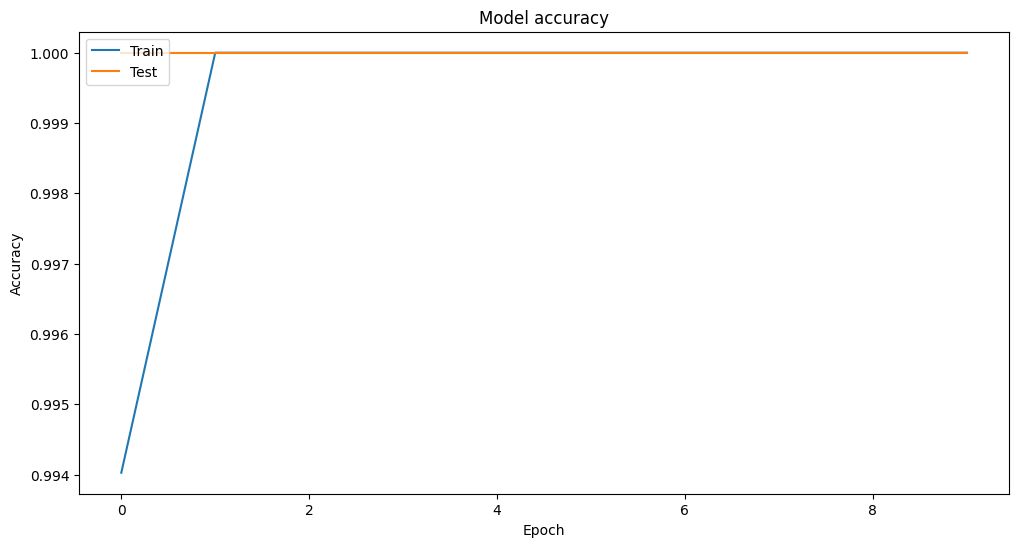

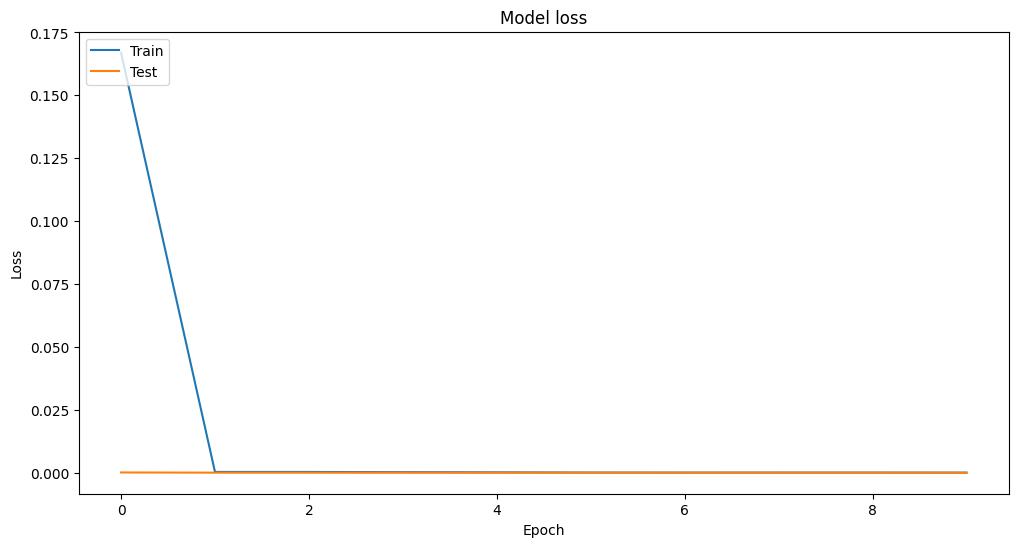

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


## Aspect Based Sentiment Analysis

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_name = "microsoft/deberta-v3-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def analyze_aspect_sentiment(text, aspect):
    inputs = tokenizer(f"{aspect} [SEP] {text}", return_tensors="pt", truncation=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    sentiment = torch.argmax(logits, dim=1).item()
    sentiment_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
    return sentiment_mapping[sentiment]

aspects = ['performance', 'battery', 'design', 'value']

for aspect in aspects:
    reviews_df[f'{aspect}_sentiment'] = reviews_df['translated_content'].apply(lambda x: analyze_aspect_sentiment(x, aspect))

reviews_df.head()

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,rating,content,variant,name,date,verified,sub_reviews,cleaned_content,translated_content,performance_sentiment,battery_sentiment,design_sentiment,value_sentiment
0,NaN,"No doubt, 12th gen Intel processors are a marv...",Style Name: Processor OnlyVerified Purchase,Anish Roy,Reviewed in India on 28 June 2022,True,[],doubt 12th gen intel processor marvel computin...,doubt 12th has intelligent processor Marvel co...,neutral,neutral,neutral,neutral
1,NaN,I have paired this processor with Asus Prime Z...,Style Name: Processor Only,Maxrock89,Reviewed in India on 29 March 2022,False,[],paired processor asus prime z690a motherboard ...,pared processor ass prime z690a motherboard 32...,neutral,neutral,neutral,neutral
2,NaN,自分のCPUが結構古いので、12年ぶりにアップグレードしました。\n最初はRYZENに迷って...,Style Name: Processor OnlyVerified Purchase,Andy,Reviewed in Japan on 25 May 2023,True,[],自分のcpuが結構古いので12年ぶりにアップグレードしました 最初はryzenに迷っていたが...,I've been upgrading my cpu for 12 years becaus...,negative,negative,negative,negative
3,NaN,"Processore eccellente, montato sul pc perfetta...",Style Name: Processor OnlyVerified Purchase,Nicolo,Reviewed in Italy on 13 February 2024,True,[],processore eccellente montato sul pc perfettam...,excellent processor mounted on the PC perfectl...,neutral,negative,neutral,neutral
4,NaN,"Does exactly what it's supposed to do, my comp...",Style Name: Processor OnlyVerified Purchase,Allan,Reviewed in Canada on 23 May 2024,True,[],exactly supposed computer work great,exactly supposed computer work great,negative,negative,neutral,negative


## Sentiment Distribution

<ipython-input-6-7c5315c5c8cb>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


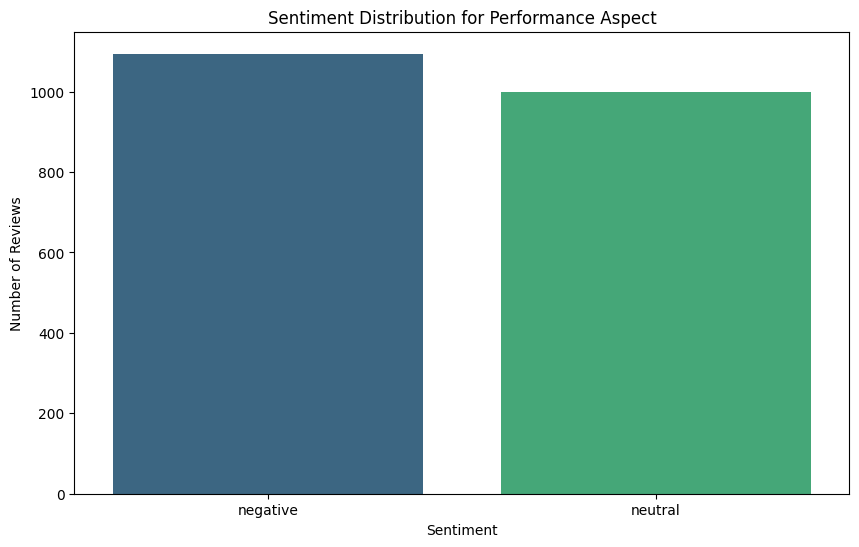

<ipython-input-6-7c5315c5c8cb>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


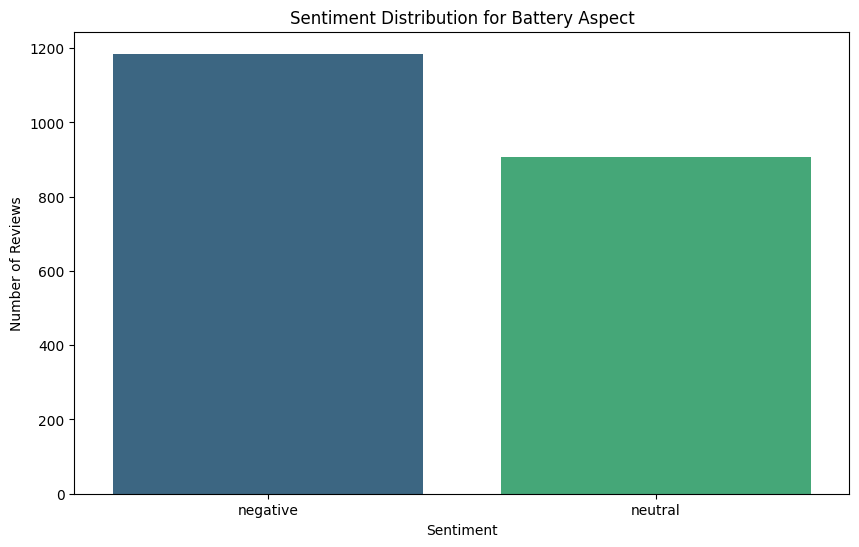

<ipython-input-6-7c5315c5c8cb>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


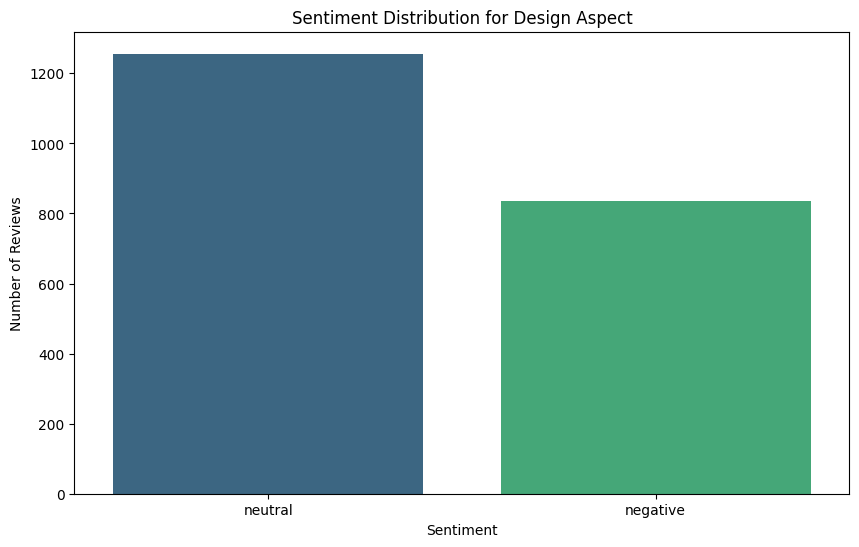

<ipython-input-6-7c5315c5c8cb>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


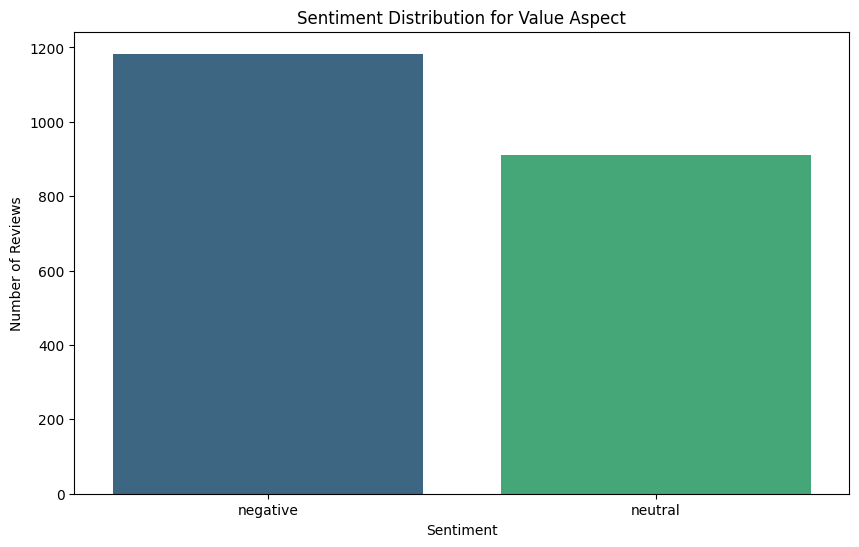

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for aspect in aspects:
    sentiment_counts = reviews_df[f'{aspect}_sentiment'].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
    plt.title(f'Sentiment Distribution for {aspect.capitalize()} Aspect')
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Reviews')
    plt.show()

### Different Aspects of Sentiment Distribution

In [ ]:
for aspect in aspects:
    sentiment_counts = reviews_df[f'{aspect}_sentiment'].value_counts()
    print(f"\n{aspect.capitalize()} Aspect Sentiment Distribution:\n{sentiment_counts}")


Performance Aspect Sentiment Distribution:
performance_sentiment
negative    1094
neutral      999
Name: count, dtype: int64

Battery Aspect Sentiment Distribution:
battery_sentiment
negative    1185
neutral      908
Name: count, dtype: int64

Design Aspect Sentiment Distribution:
design_sentiment
neutral     1256
negative     837
Name: count, dtype: int64

Value Aspect Sentiment Distribution:
value_sentiment
negative    1183
neutral      910
Name: count, dtype: int64


## Save Cleaned Data

In [ ]:

cleaned_reviews_df = reviews_df[['translated_content'] + [f'{aspect}_sentiment' for aspect in aspects]]

cleaned_csv_path = 'translated_reviews_with_sentiment.csv'
cleaned_reviews_df.to_csv(cleaned_csv_path, index=False)

print(f"Cleaned reviews saved to {cleaned_csv_path}")

Cleaned reviews saved to cleaned_reviews_aspect_based.csv


## FastText Model Training

In [ ]:
model = fasttext.train_supervised(input='train.txt', epoch=25, lr=1.0, wordNgrams=2, verbose=2, minCount=1)

result = model.test('valid.txt')
print('Validation set accuracy:', result[1])


Validation set accuracy: 1.0


In [ ]:
validation_accuracy = result[1]

print(f'Final Validation Accuracy: {validation_accuracy:.4f}')


Final Validation Accuracy: 1.0000


## Prediction and Visualization

Skipping invalid line: __label__0 

Skipping invalid line: __label__0 

Skipping invalid line: __label__0 

Skipping invalid line: __label__0 

[['__label__0', '"the processor was easy to put on a b760 gigabyte go super fast"'], ['__label__0', '"too nice powerful build PC around video photo editing building setup job nicely"'], ['__label__0', 'Okay.'], ['__label__0', '"impressive cpu almost by i9 slightly four ecores editor creator sort really where miss gambling wise cpu hit benchmark solid score cinemabunch time run small hot gambling together thing roughly around 65 72c highest time right cooler printed as stock cooler would recommend"'], ['__label__0', '"it works perfectly well because I come from an i5 eighth generation already with a gpu 4070 I\'ll have your experience in this"']]


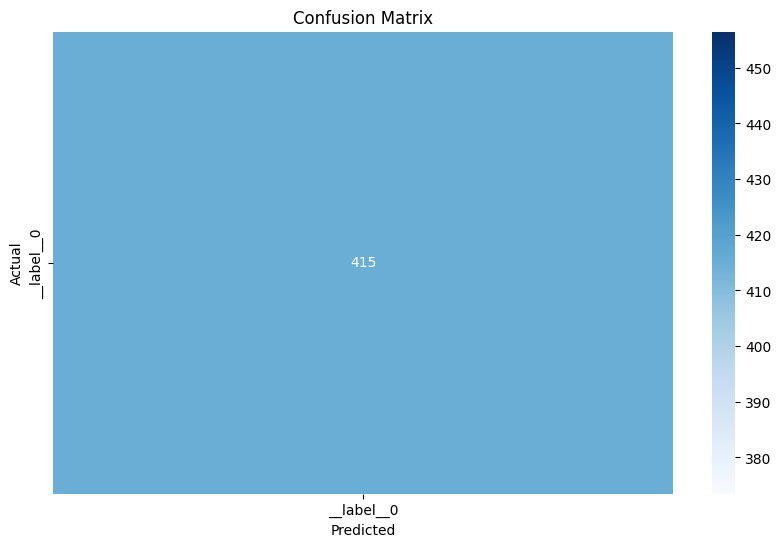

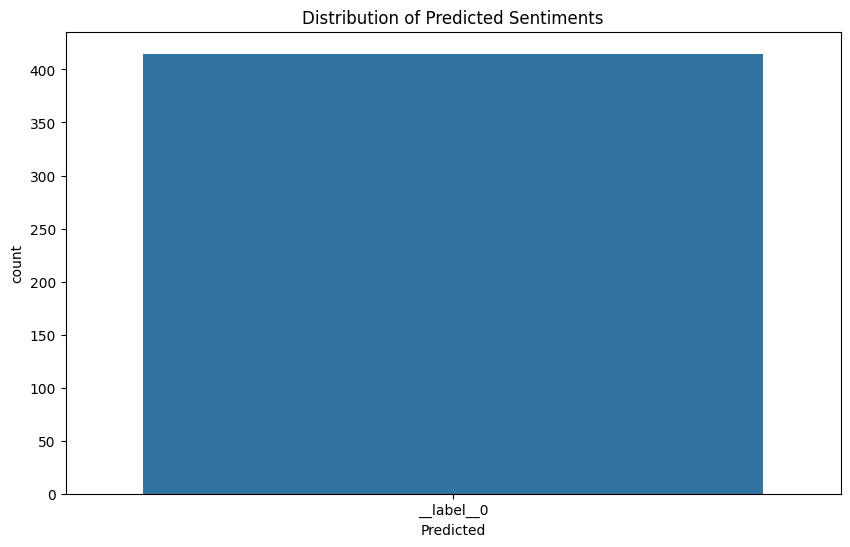

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

valid_data = []
with open('valid.txt', 'r') as file:
    for line in file:
        parts = line.strip().split(' ', 1)
        if len(parts) == 2:
            valid_data.append(parts)
        else:
            print(f"Skipping invalid line: {line}")

print(valid_data[:5])

predictions = [model.predict(text)[0][0] for label, text in valid_data]
actuals = [label for label, text in valid_data]

df_pred = pd.DataFrame({'Actual': actuals, 'Predicted': predictions})

conf_matrix = pd.crosstab(df_pred['Actual'], df_pred['Predicted'], rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Predicted', data=df_pred)
plt.title('Distribution of Predicted Sentiments')
plt.show()


## LSTM model Training

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

embedding_dim = 64

model = Sequential([
    Embedding(input_dim=5000, output_dim=embedding_dim, input_length=max_length),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_padded, y_train, epochs=5, validation_data=(X_test_padded, y_test), batch_size=32)


Epoch 1/5
53/53 [==============================] - 46s 719ms/step - loss: 0.1254 - accuracy: 0.9809 - val_loss: 6.9952e-04 - val_accuracy: 1.0000
Epoch 2/5
53/53 [==============================] - 20s 373ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 3.6357e-04 - val_accuracy: 1.0000
Epoch 3/5
53/53 [==============================] - 19s 363ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 2.4953e-04 - val_accuracy: 1.0000
Epoch 4/5
53/53 [==============================] - 19s 351ms/step - loss: 9.6019e-04 - accuracy: 1.0000 - val_loss: 1.6554e-04 - val_accuracy: 1.0000
Epoch 5/5
53/53 [==============================] - 21s 385ms/step - loss: 6.5688e-04 - accuracy: 1.0000 - val_loss: 1.3445e-04 - val_accuracy: 1.0000


## Model Evaluation

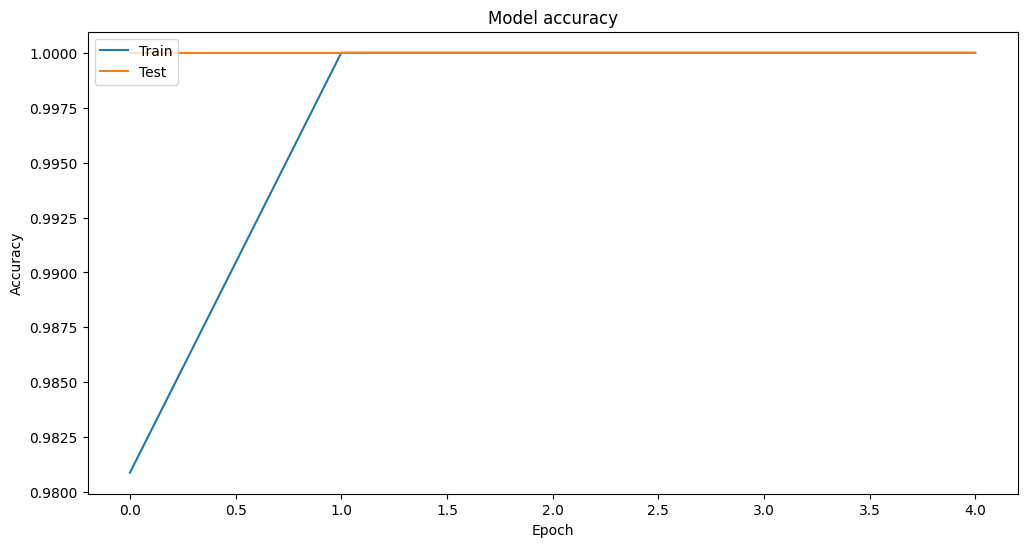

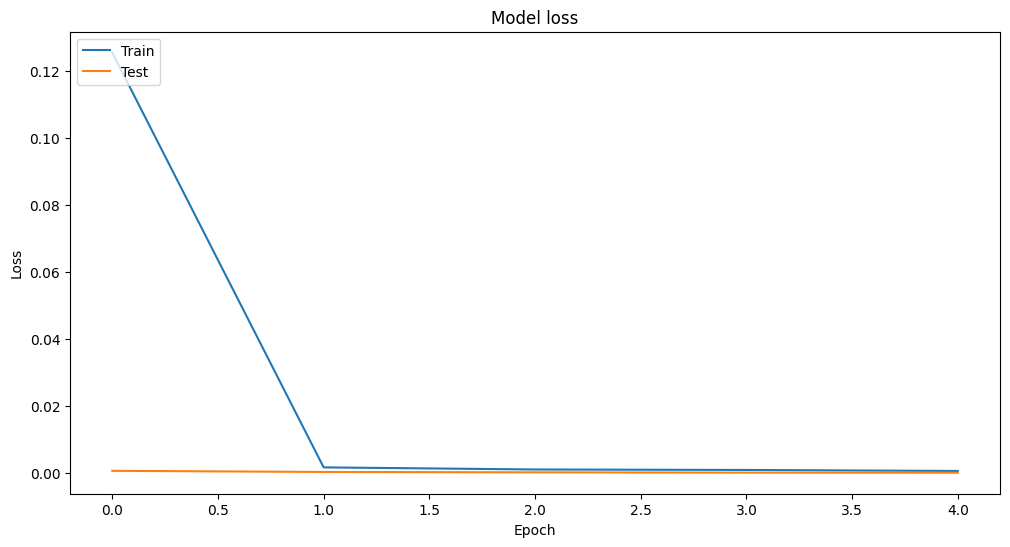

14/14 - 1s - loss: 1.3445e-04 - accuracy: 1.0000 - 1s/epoch - 84ms/step
Test Accuracy: 1.00


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

loss, accuracy = model.evaluate(X_test_padded, y_test, verbose=2)
print(f'Test Accuracy: {accuracy:.2f}')


## Sentiment Analysis using NLTK

In [ ]:

from transformers import pipeline, AutoTokenizer, TFAutoModelForSequenceClassification

model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_model = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

def analyze_sentiment(text):
    result = sentiment_model(text, truncation=True, max_length=512)
    label = result[0]['label']
    if label in ['1 star', '2 stars']:
        return 'negative'
    elif label == '3 stars':
        return 'neutral'
    else:
        return 'positive'

reviews_df['sentiment'] = reviews_df['translated_content'].apply(analyze_sentiment)

reviews_df[['translated_content', 'sentiment']].head()


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/670M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


,translated_content,sentiment
0,doubt 12th has intelligent processor Marvel co...,positive
1,pared processor ass prime z690a motherboard 32...,positive
2,I've been upgrading my cpu for 12 years becaus...,positive
3,excellent processor mounted on the PC perfectl...,positive
4,exactly supposed computer work great,positive


## Sentiment Distribution

<ipython-input-8-213c2308a608>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


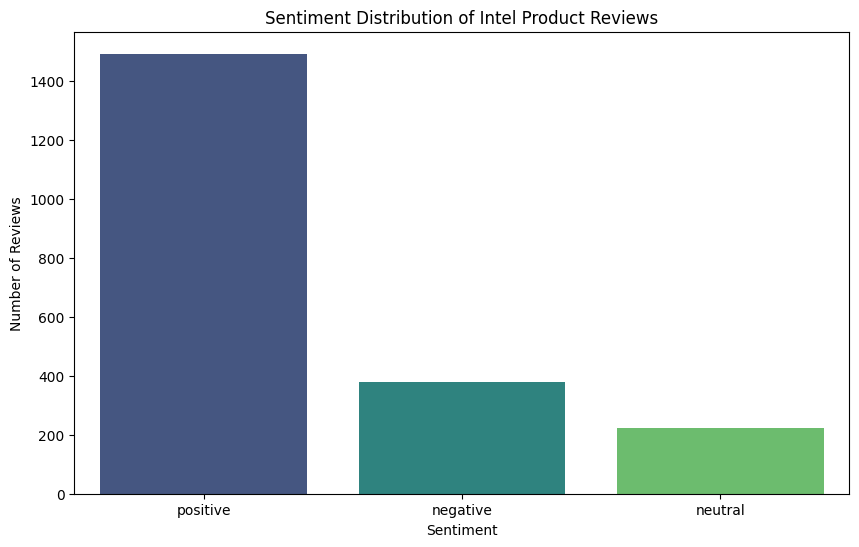

sentiment
positive    1493
negative     378
neutral      222
Name: count, dtype: int64

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

sentiment_counts = reviews_df['sentiment'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Distribution of Intel Product Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

sentiment_counts


## Sentiment Analysis with RoBERTa

In [ ]:

from transformers import pipeline

sentiment_model = pipeline('sentiment-analysis', model='cardiffnlp/twitter-roberta-base-sentiment')

def analyze_sentiment_roberta(text):
    result = sentiment_model(text, truncation=True, max_length=512)
    return result[0]['label'].lower()

reviews_df['sentiment'] = reviews_df['cleaned_content'].apply(analyze_sentiment_roberta)

reviews_df[['cleaned_content', 'sentiment']].head()


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


,cleaned_content,sentiment
0,no doubt 12th gen intel processors are a marve...,label_2
1,i have paired this processor with asus prime z...,label_2
2,cpu12 ryzen ryzencpu pc,label_1
3,processore eccellente montato sul pc perfettam...,label_1
4,does exactly what its supposed to do my comput...,label_2


## Sentiment Distribution

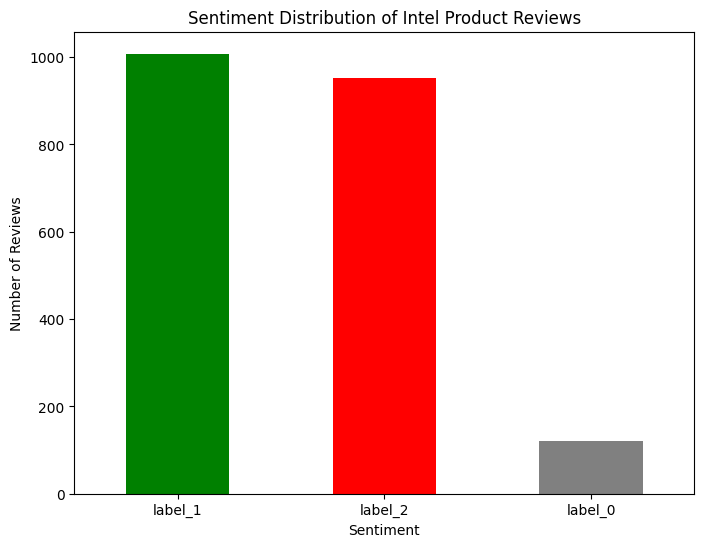

sentiment
label_1    1008
label_2     951
label_0     120
Name: count, dtype: int64

In [ ]:

import matplotlib.pyplot as plt

sentiment_counts = reviews_df['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'gray'])
plt.title('Sentiment Distribution of Intel Product Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()

sentiment_counts


## Fine-Tuning ULMFiT Model

In [ ]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.000000,0.000000,1.000000,00:03


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,accuracy,time
0,0.000000,0.000000,1.000000,00:03
1,0.000000,0.000000,1.000000,00:07
2,0.000000,0.000000,1.000000,00:04
3,0.000000,0.000000,1.000000,00:05


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

## Visualization of Training and Validation Metrics

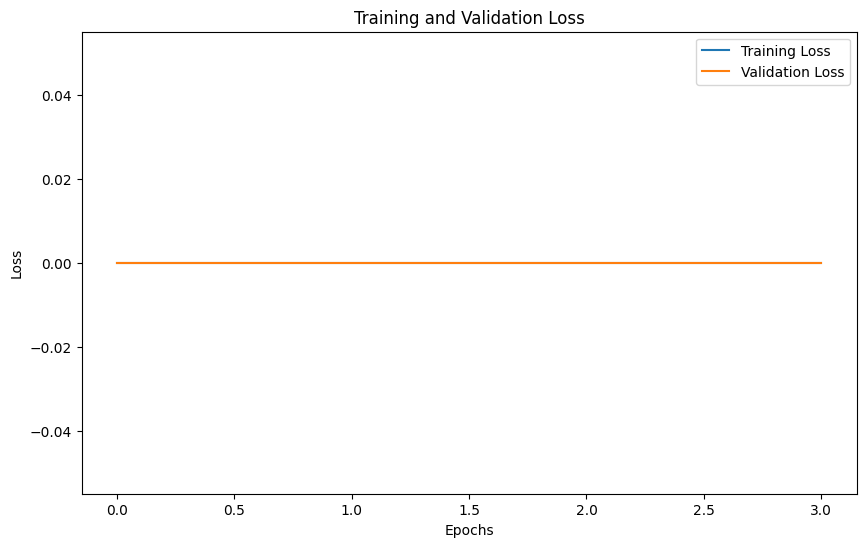

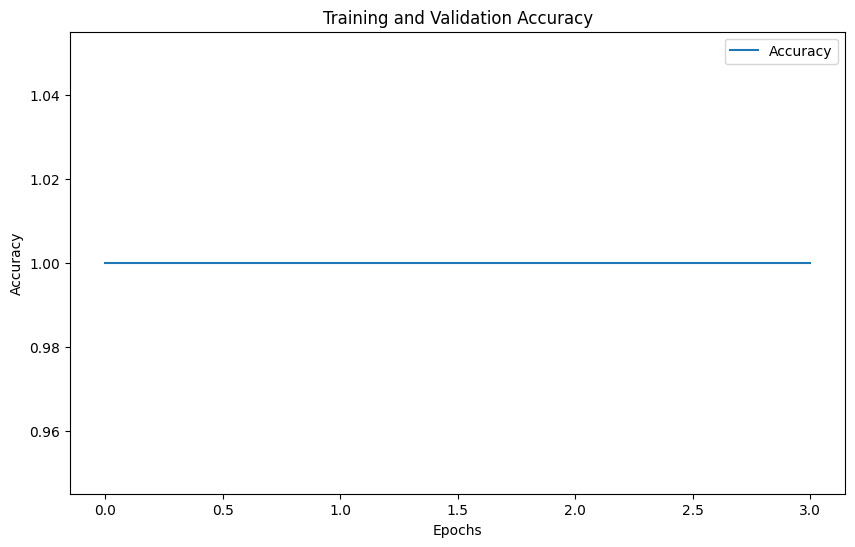

,text,category,category_
0,"xxbos xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy , xxmaj i 'm happy ,",0,0
1,xxbos i have a gtx 1070 t that i had before xxunk with an i5 7500 thinking it was enough to play xxunk i had to xxunk when i made xxunk with this processor 7500 did bottleneck a little more than once for example on code xxunk i got between 90 and 120 fps since i placed the 9600k i am almost always on 144 fps while war zone does n't fall under 120 on rainbow six even better all the way down under 144 fps is almost like having changed even video card and it 's fantastic,0,0
2,xxbos xxmaj your many new i9 i7 port xxunk board anything lga 1200 slot waste newest new guy get your own gon on xxunk capacity get 10th get save money your gon on need new board water cool thing xxmaj gen 4 nvme drive new 30 xxunk reason use xxunk 4 pcie slot here xxunk good starting point getting cpu step 1 get 11th xxmaj gen processor i9 budget step 2 get parentboard gen 4 pcie slot xxunk go step 3 obviously cool beauty reason would get 53ghz done safely cursor xxunk xxmaj xxunk,0,0
3,xxbos enough power play game single one xxunk us 50 cpu play gta 5 satisfaction far cry 6 city skyline even play xxunk 2 4 xxunk xxunk against their hit 100 benchmark i3 think xxunk 12th ge i3 powerful i7 generation buy i5 i7 enough update xxunk processor still going strong still game modern run his xxunk like field never xxunk 100 xxunk found 2 game stroke run star xxunk xxunk zone xxmaj xxunk 100 entire xxwrep 3 time xxmaj xxunk zone xxunk still run 80fps extra setting 4k star city bad,0,0
4,"xxbos xxmaj for the first time i have to say that delivery really fixed went term for the next week was xxunk but then xxunk were already released i thought i could only xxunk all the parts together and e can go together so i started to pack everything right up there and then the cpu was xxunk why the packaging was already on , but i did n't go any further i made the packaging where the cpu should now be up and saw a height of no great thought i",0,0
5,xxbos phenomenon upgrading i5 12400f best cpu pro xxunk spec rtx 4070ti z790 ddr5 gigabyte mobo 32 gb xxmaj xxunk ram 1 tb wd black ssd gene 4 per core noticeable fast area like xxunk application triple gpu xxunk game get noticeable fps boost xxunk talking xxunk cpu body game emulator get much better stability cpu use xxunk with looking energy efficiency 13th gen higher chip core mean power draw surre triple game chip using 2030 watt electricity emulator like xxunk near double went 30 40 watt average average 80 instance,0,0
6,xxbos xxunk the product that came to me for the first time if such a cpu was xxunk with an xxunk above with intellectual writing i5 9600k and with fake xxunk xxunk xxunk the motherboard mobile card talking to the xxunk there are no cpus with top xxunk made xxunk xxunk and they thought it was a trick although the xxunk product was fake but it managed to close my eye thanks to its media performance by making 60 fps on games as strong only with the gpu,0,0
7,xxbos xxmaj no doubt this processor when being a series k gives more xxunk than overclock in question games has enough performance to play in a media range you need to have a very powerful processor to play 4k in that case you need to invest more in a more powerful graphics card something necessary to know and that it is mentioned that it has a turbo frequency of 46 gz but this and maximum frequency per single xxunk could xxunk this frequency with a little overclock for,0,0
8,xxbos 

In [ ]:
import matplotlib.pyplot as plt

train_losses = [val[0] for val in learn.recorder.values]
valid_losses = [val[1] for val in learn.recorder.values]
accuracies = [val[2] for val in learn.recorder.values]
epochs = range(len(train_losses))

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracies, label='Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

learn.show_results()


## Sentiment Analysis by VADER

In [ ]:

from textblob import TextBlob

def analyze_sentiment_textblob(text):
    blob = TextBlob(text)
    if blob.sentiment.polarity > 0:
        return 'positive'
    elif blob.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

reviews_df['sentiment'] = reviews_df['cleaned_content'].apply(analyze_sentiment_textblob)

reviews_df[['cleaned_content', 'sentiment']].head()


,cleaned_content,sentiment
0,no doubt 12th gen intel processors are a marve...,positive
1,i have paired this processor with asus prime z...,positive
2,cpu12 ryzen ryzencpu pc,neutral
3,processore eccellente montato sul pc perfettam...,neutral
4,does exactly what its supposed to do my comput...,positive


## Sentiment Distribution

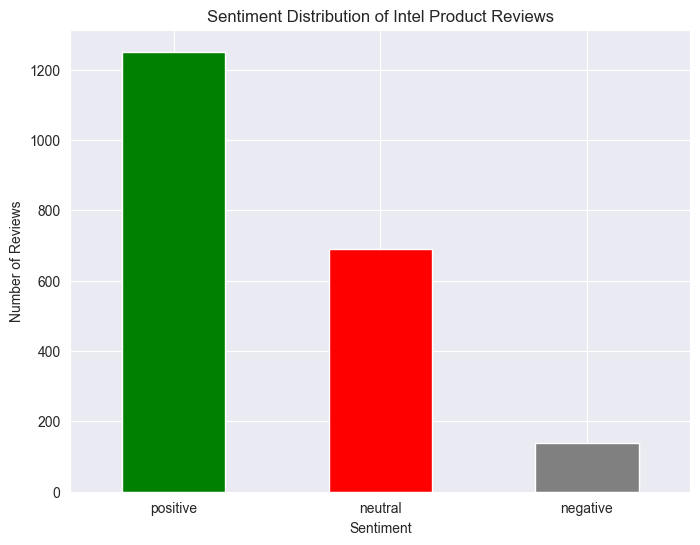

sentiment
positive    1251
neutral      690
negative     138
Name: count, dtype: int64

In [ ]:

import matplotlib.pyplot as plt

sentiment_counts = reviews_df['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'gray'])
plt.title('Sentiment Distribution of Intel Product Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()

sentiment_counts


## Generating WORDCLOUD of Reviews
This helps us find out the most frequently used words in the reviews

In [ ]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk import sent_tokenize,word_tokenize
import nltk
from tqdm.notebook import tqdm
def wc(data,bgc,title):
    plt.figure(figsize=(100,100))
    wc=WordCloud(background_color=bgc,max_words=500,max_font_size=50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
n_df=pd.read_csv('cleaned_reviews_textblob.csv')
stop_words = list(stopwords.words('english'))
pos_sen_content=n_df[n_df['sentiment']=='positive']
neu_sen_content=n_df[n_df['sentiment']=='neutral']
neg_sen_content=n_df[n_df['sentiment']=='negative']

In [ ]:
print(pos_sen_content.isnull().sum())

index              0
cleaned_content    0
sentiment          0
dtype: int64


In [ ]:
print(neu_sen_content.isnull().sum())

index               0
cleaned_content    23
sentiment           0
dtype: int64


In [ ]:
print(neg_sen_content.isnull().sum())

index              0
cleaned_content    0
sentiment          0
dtype: int64


In [ ]:
# Filling nan datas with an empty string
neu_sen_content=neu_sen_content.fillna('')

In [ ]:
pos_sen_content.reset_index(inplace=True)
neu_sen_content.reset_index(inplace=True)
neg_sen_content.reset_index(inplace=True)

In [ ]:
# len(pos_sen_content)
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## WordCloud of Positive Reviews

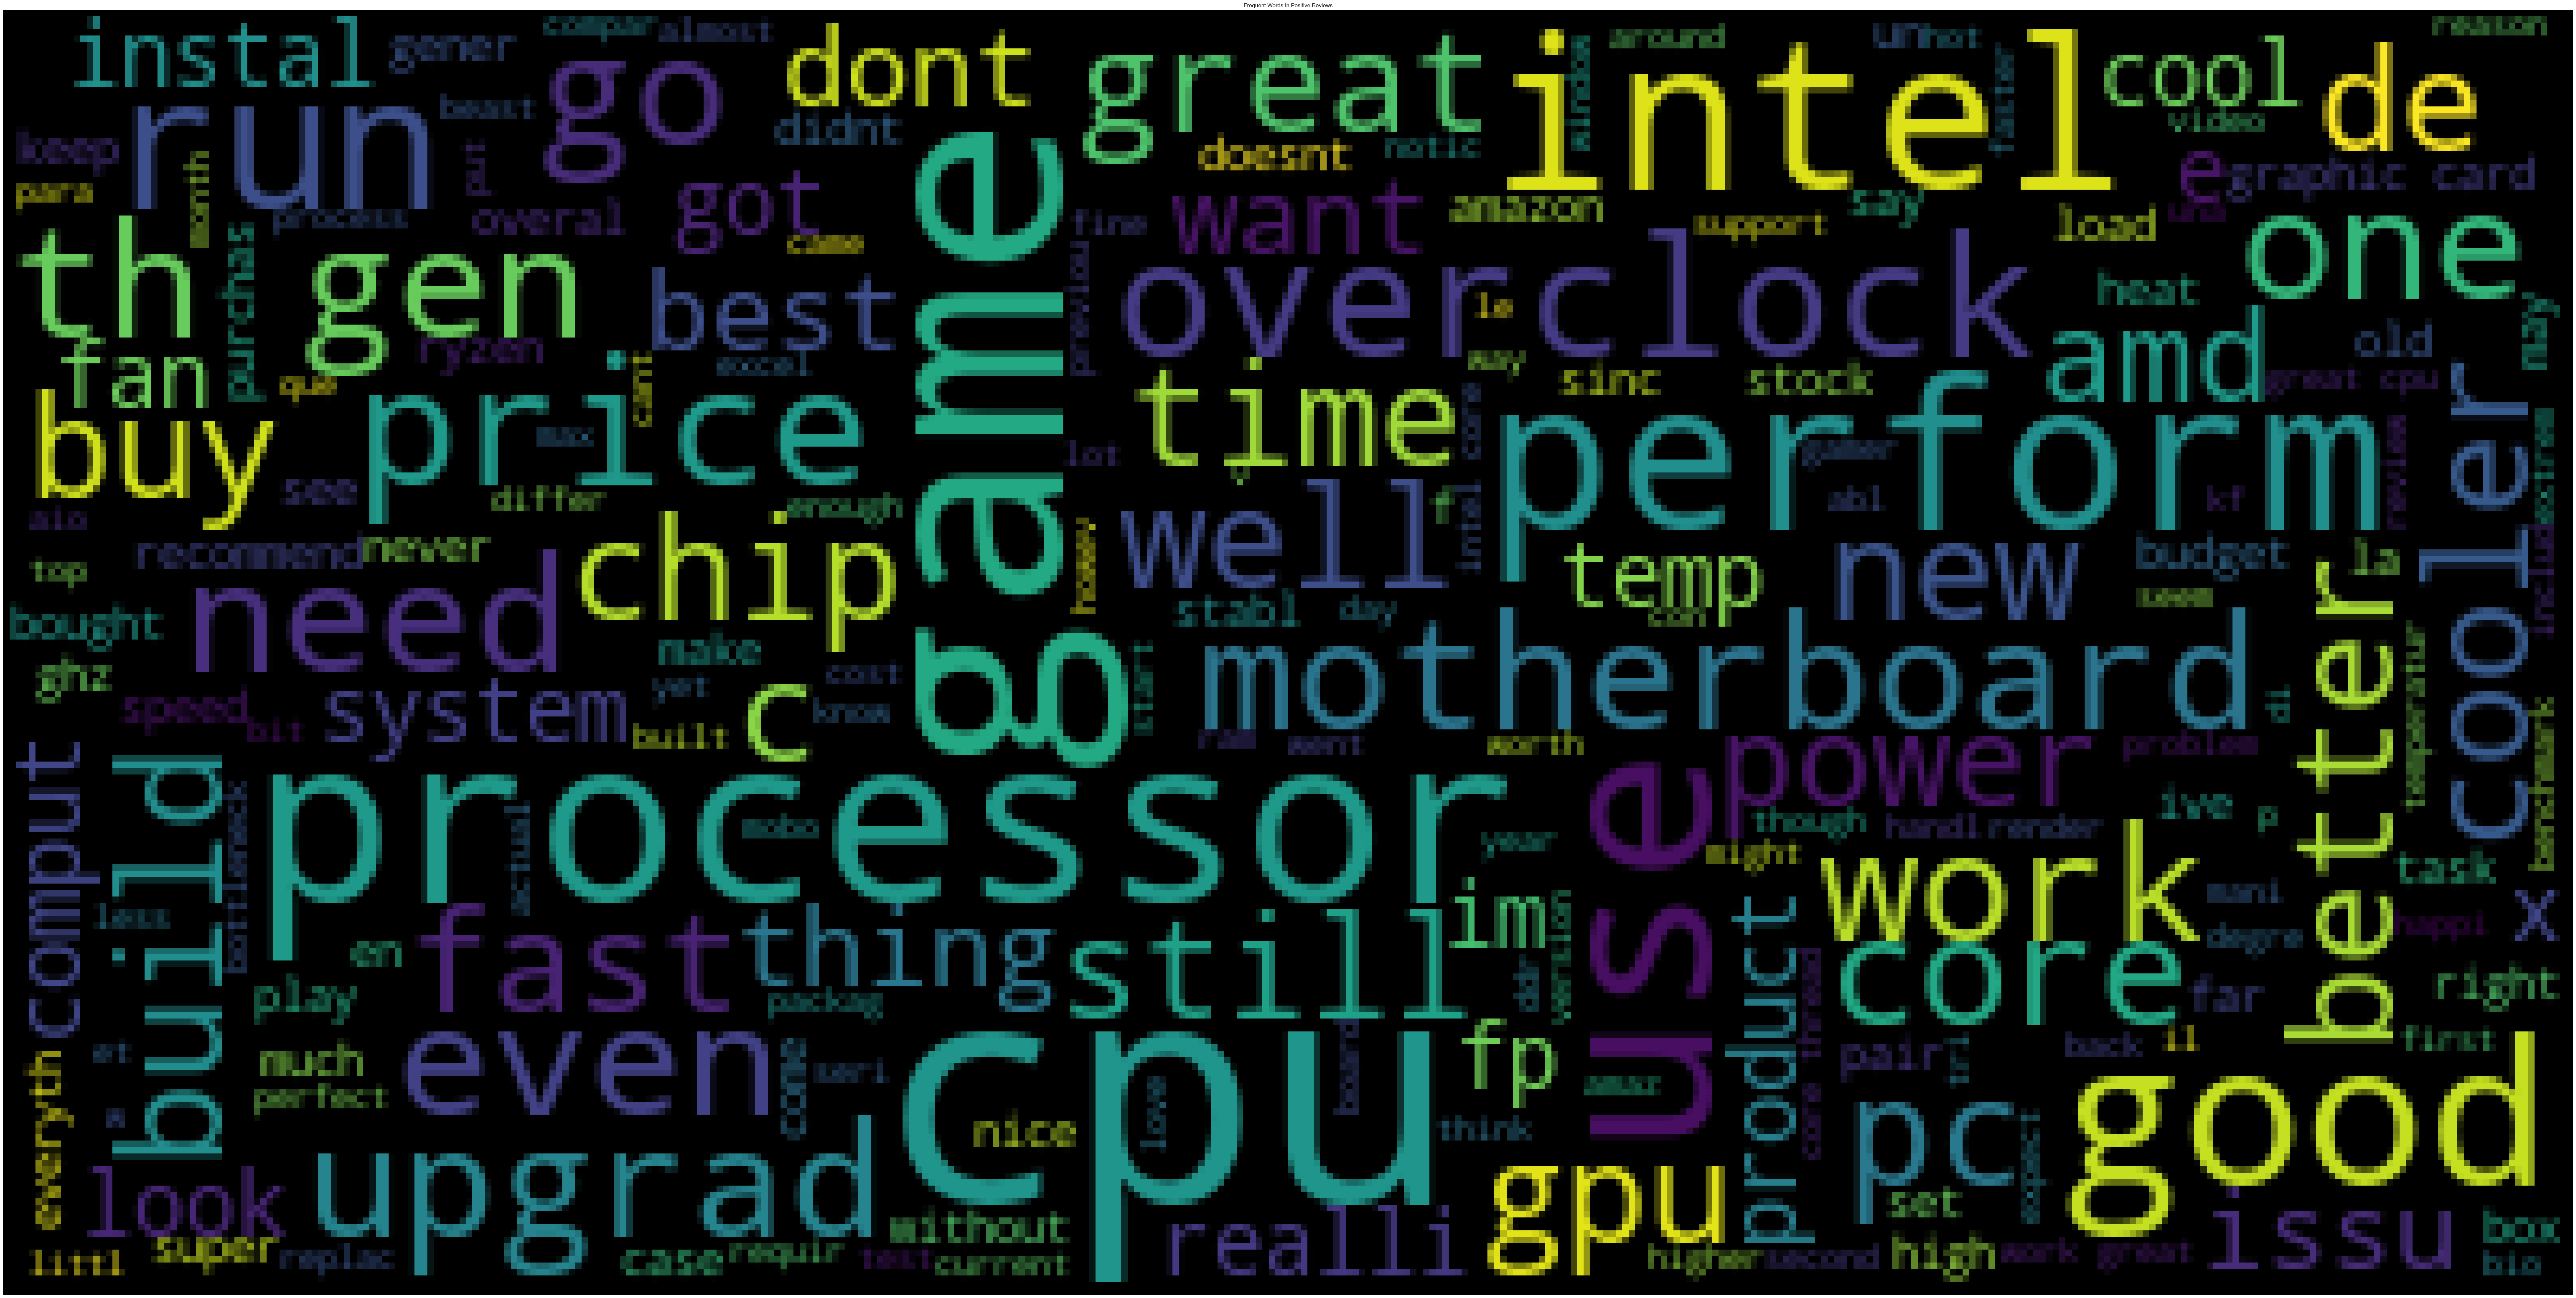

In [ ]:
corpus=[]
for i in range(0,len(pos_sen_content)):
    review = re.sub(pattern='[^a-zA-Z]',repl=' ',string=pos_sen_content["cleaned_content"][i])
    review = review.lower()
    review = review.split()
    ps=PorterStemmer()
    stop_words=stopwords.words('english')
    stop_words.remove("not")
    review = [ps.stem(word) for word in review if not word in set(stop_words)]
    review = ' '.join(review)
    corpus.append(review)
wc(corpus,'black','Frequent Words In Positive Reviews')

## WordCloud of Neutral Reviews

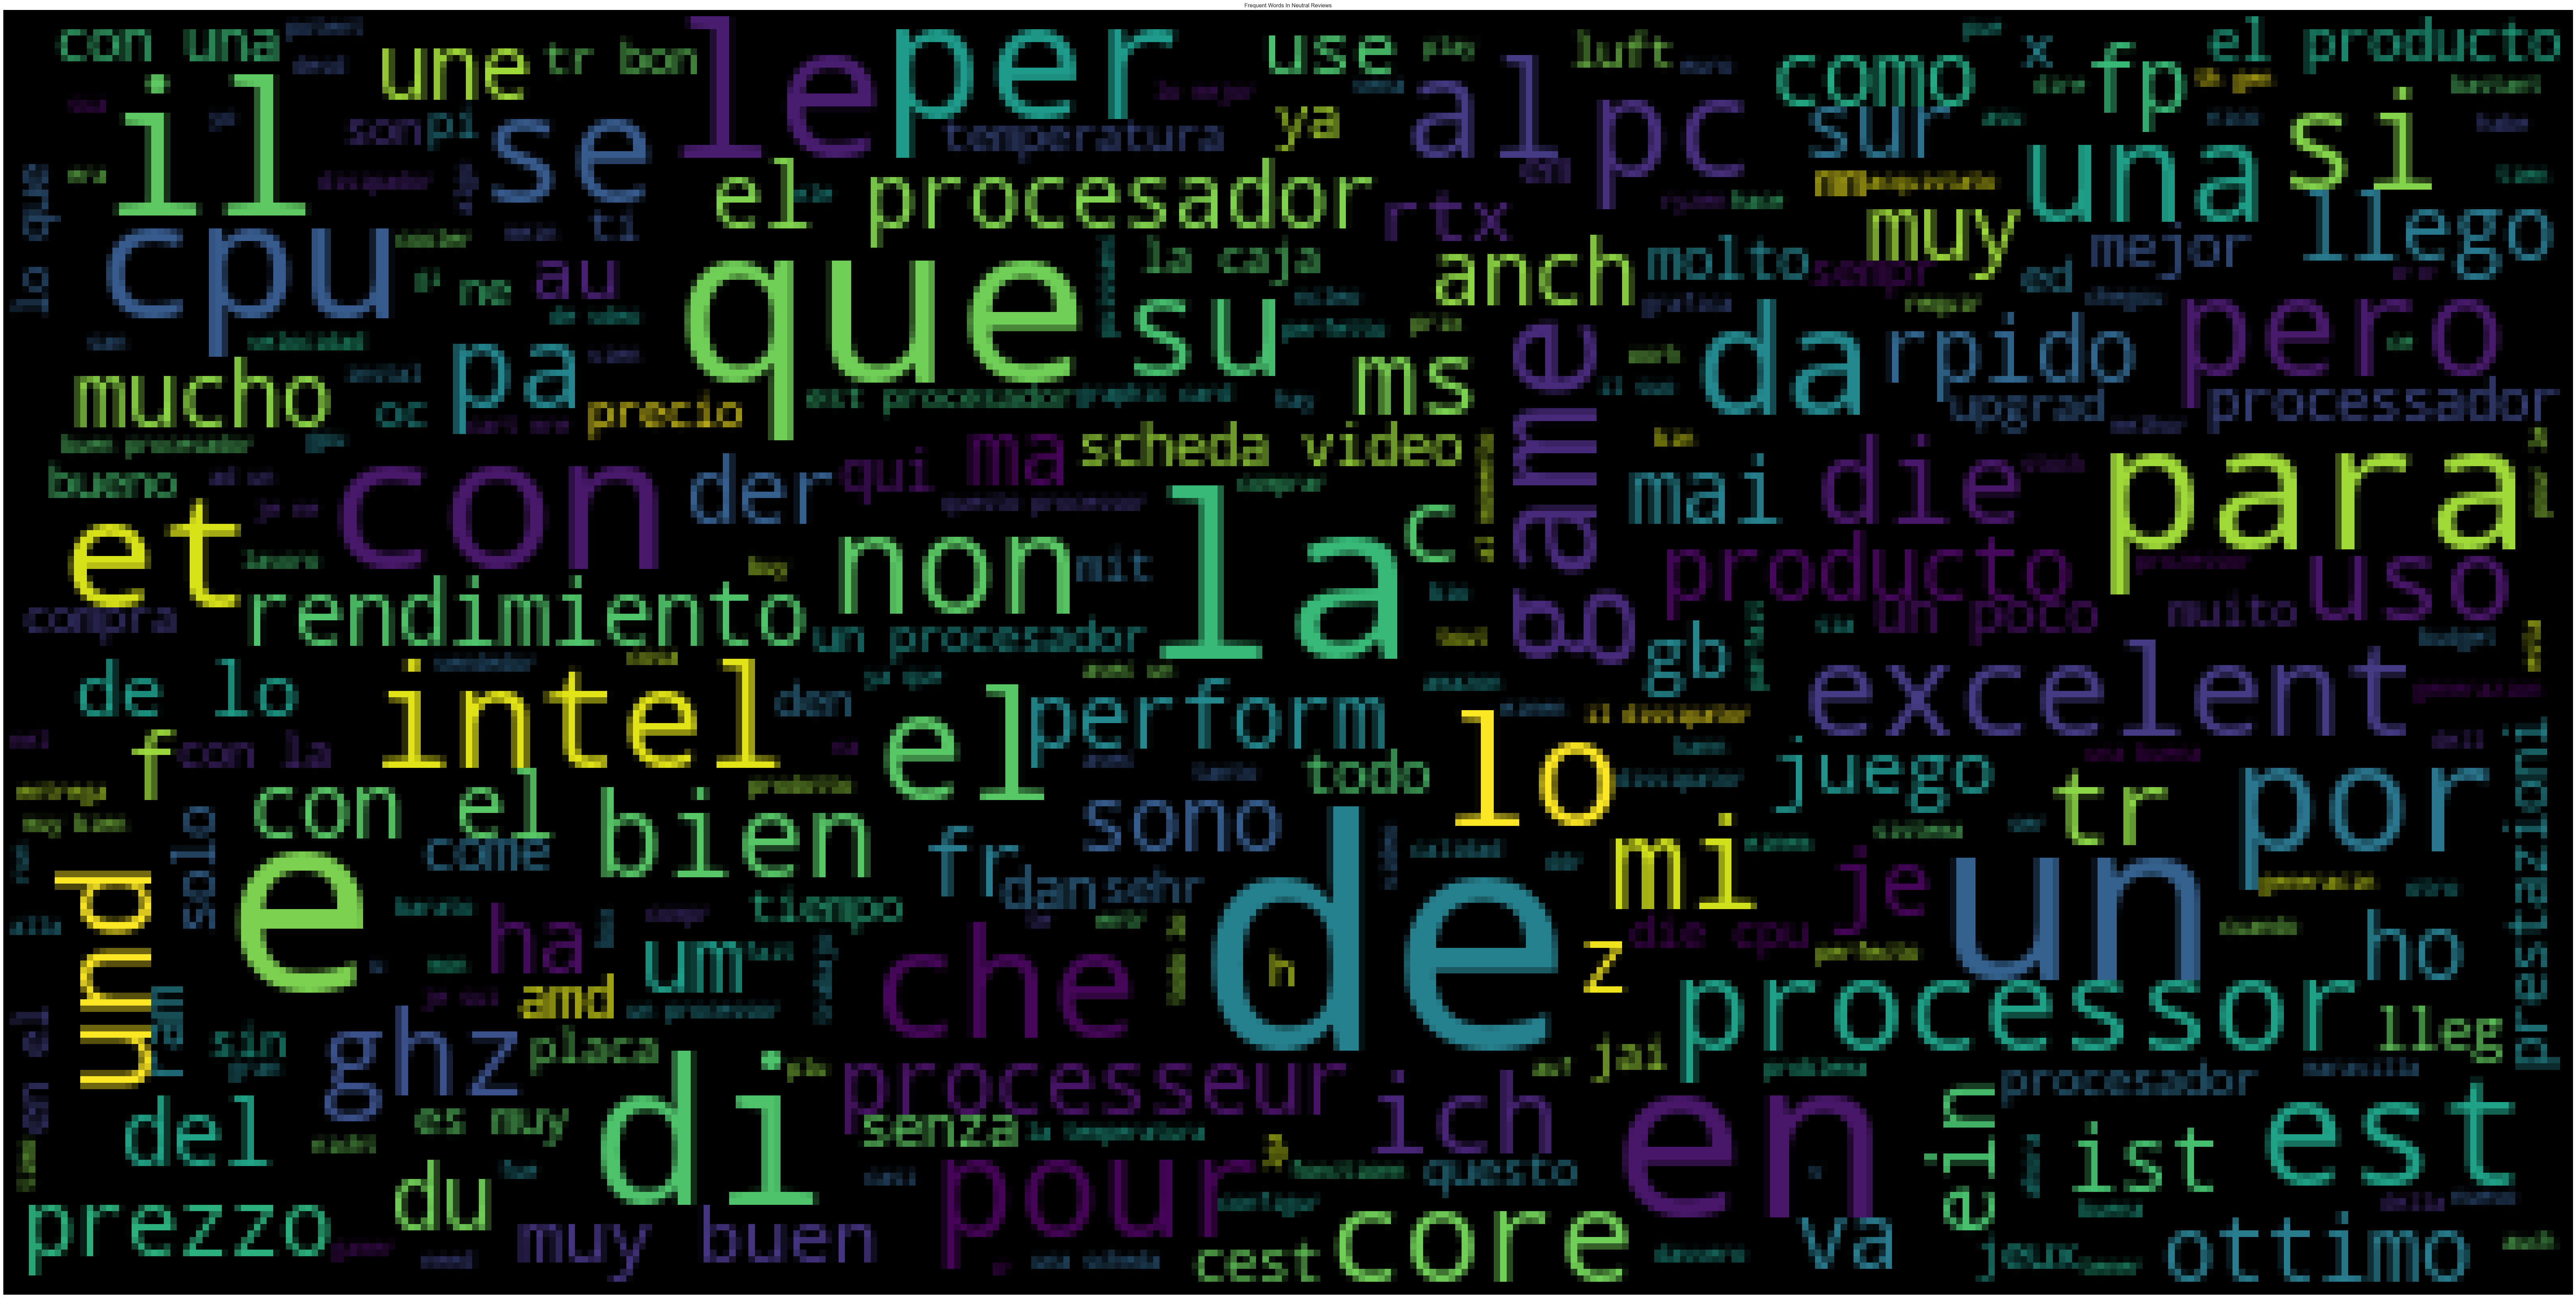

In [ ]:
corpus=[]
for i in range(0,len(neu_sen_content)):
    review = re.sub(pattern='[^a-zA-Z]',repl=' ',string=neu_sen_content["cleaned_content"][i])
    review = review.lower()
    review = review.split()
    # ps=PorterStemmer()
    stop_words=stopwords.words('english')
    stop_words.remove("not")
    review = [ps.stem(word) for word in review if not word in set(stop_words)]
    review = ' '.join(review)
    corpus.append(review)
wc(corpus,'black','Frequent Words In Neutral Reviews')

## WordCloud of Negative Reviews

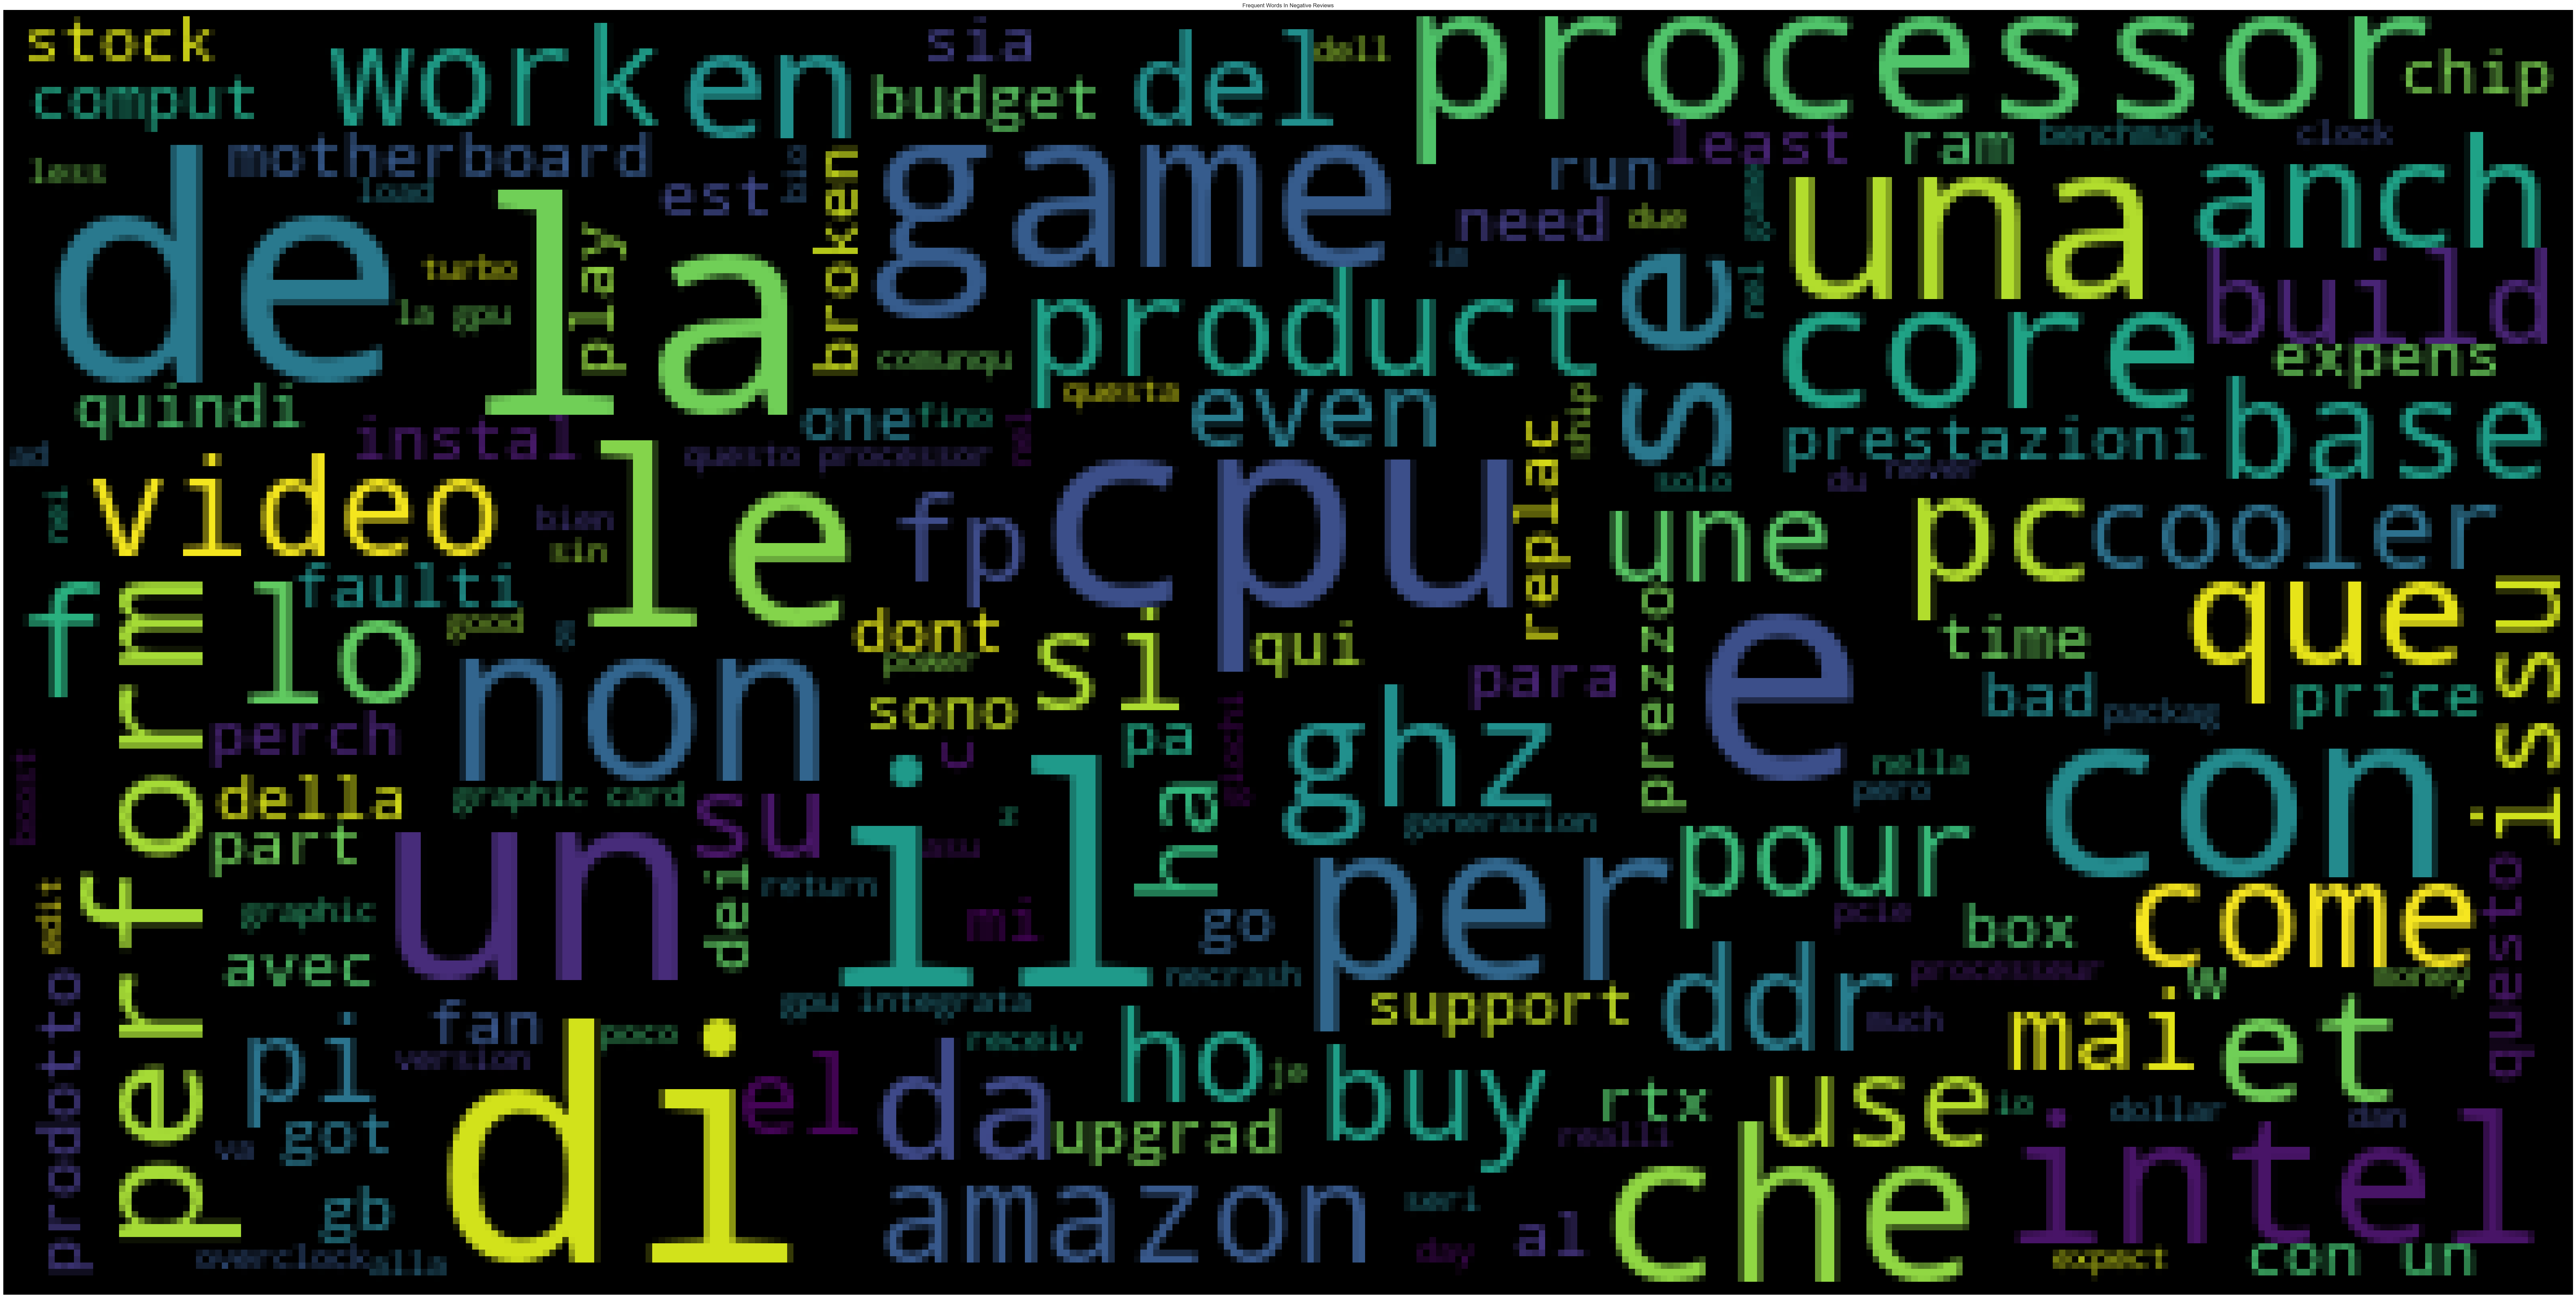

In [ ]:
corpus=[]
for i in range(0,len(neg_sen_content)):
    review = re.sub(pattern='[^a-zA-Z]',repl=' ',string=neg_sen_content["cleaned_content"][i])
    review = review.lower()
    review = review.split()
    # ps=PorterStemmer()
    stop_words=stopwords.words('english')
    stop_words.remove("not")
    review = [ps.stem(word) for word in review if not word in set(stop_words)]
    review = ' '.join(review)
    corpus.append(review)
wc(corpus,'black','Frequent Words In Negative Reviews')

## Insights and Recommendations


### Sentiment Distribution

- **Positive Reviews**: The majority of the reviews are positive, indicating a generally favorable perception of Intel products among customers.
- **Neutral Reviews**: A significant number of reviews are neutral, suggesting areas where improvements or more detailed feedback might be provided.
- **Negative Reviews**: Although relatively few, negative reviews highlight areas where customers are dissatisfied.

### Recommendations

1. **Strengthen Positives**: Leverage the aspects customers are happy with, such as performance and compatibility, to market the products more effectively.
2. **Address Neutral Feedback**: Investigate the neutral reviews to understand what might be missing or unclear. Provide more detailed product information and support to convert neutral feedback into positive.
3. **Improve Negatives**: Focus on the areas highlighted in negative reviews. Common issues might include product quality, customer service, or specific features that need improvement.
